#### load packages & data

In [71]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.tree import export_graphviz

In [57]:
data = pd.read_csv('breast-cancer.txt', header=None)
data.columns= ['c', 'age', 'menopause', 'tumor_size', 'inv_nodes', 
              'node_caps', 'deg_malig', 'breast', 'breast_quad', 'irradiat']
data.head()

,c,age,menopause,tumor_size,inv_nodes,node_caps,deg_malig,breast,breast_quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor-size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    286 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  286 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


- na 데이터 처리

In [40]:
data['node_caps'].value_counts()

no     222
yes     56
?        8
Name: node_caps, dtype: int64

In [41]:
data['breast_quad'].value_counts()

left_low     110
left_up       97
right_up      33
right_low     24
central       21
?              1
Name: breast_quad, dtype: int64

na값을 갖는 데이터가 많지 않고, na값이 있는 두 변수 모두 범주형 자료이므로 변수의 평균 등의 값으로 대체할 수 없으므로 na값이 존재하는 행은 삭제한다.

In [58]:
naidx = data[(data['node_caps'] == '?') | (data['breast_quad'] == '?')].index
data = data.drop(index=naidx, axis=0)

## 1. Logistic regression fitting

#### 1) recurrence event 확률을 예측하시오.

train set으로 모델을 적합하고 test set을 예측하기 위해 전체 data set을 train과 test로 분리한다.

In [61]:
X = pd.get_dummies(data.drop("c", axis=1))
y = data['c']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, 
                                                   random_state=777)
train_x.head()

,deg_malig,age_20-29,age_30-39,age_40-49,age_50-59,age_60-69,age_70-79,menopause_ge40,menopause_lt40,menopause_premeno,...,node_caps_yes,breast_left,breast_right,breast_quad_central,breast_quad_left_low,breast_quad_left_up,breast_quad_right_low,breast_quad_right_up,irradiat_no,irradiat_yes
214,2,0,0,0,0,1,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
276,3,0,1,0,0,0,0,0,0,1,...,1,1,0,0,0,0,1,0,0,1
199,1,0,0,0,1,0,0,0,0,1,...,0,1,0,0,1,0,0,0,1,0
56,1,0,0,0,1,0,0,1,0,0,...,0,0,1,1,0,0,0,0,1,0
93,2,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0


model fitting

In [62]:
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

lreg = LogisticRegression(solver = "lbfgs", random_state= 777)
lreg.fit(train_x, train_y)

LogisticRegression(random_state=777)

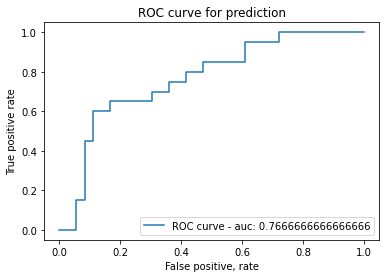

In [63]:
# predict
pred_y_prob = lreg.predict_proba(test_x)
pred_y_1 = pred_y_prob[:, 1]
test_y_int = [1 if i == 'recurrence-events' else 0 for i in test_y]
fpr, tpr, thres = roc_curve(test_y_int, pred_y_1)
plt.plot(fpr, tpr, label="ROC curve - auc: {}".format(auc(fpr, tpr)))
plt.legend()
plt.xlabel("False positive, rate")
plt.ylabel("True positive rate")
plt.title("ROC curve for prediction")
plt.show()

In [8]:
pred_y_prob[:10]

array([[0.01673209, 0.98326791],
       [0.89615972, 0.10384028],
       [0.99468018, 0.00531982],
       [0.48185408, 0.51814592],
       [0.67166422, 0.32833578],
       [0.54503365, 0.45496635],
       [0.75691634, 0.24308366],
       [0.9336053 , 0.0663947 ],
       [0.79990349, 0.20009651],
       [0.91432854, 0.08567146]])

#### 2) recurrence event 확률에 영향을 미치는 변수를 파악하시오.

In [64]:
# model fitting with stasmodel module
train_x, test_x, train_y, test_y = train_test_split(data.drop("c", axis=1), data['c'], test_size=0.2, 
                                                   random_state=777)

f = 'c~age+menopause+tumor_size+inv_nodes+node_caps+deg_malig+breast+breast_quad+irradiat'
train = pd.concat([train_x, pd.DataFrame(train_y)], axis=1)
model = smf.glm(formula=f, data=train, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                                  Generalized Linear Model Regression Results                                  
Dep. Variable:     ['c[no-recurrence-events]', 'c[recurrence-events]']   No. Observations:                  221
Model:                                                             GLM   Df Residuals:                      189
Model Family:                                                 Binomial   Df Model:                           31
Link Function:                                                   logit   Scale:                          1.0000
Method:                                                           IRLS   Log-Likelihood:                -100.98
Date:                                                 Thu, 14 Oct 2021   Deviance:                       201.96
Time:                                                         22:33:44   Pearson chi2:                     202.
No. Iterations:                                                     21                                  

model summary 결과에 따르면 deg_malig , inv_nodes 변수의 3-5와 6-8, irradiat 변수가 종속변수에 유의한 영향을 미친다.

## 2. Regression tree fitting

#### 1) recurrence event 확률을 예측하시오

In [67]:
X = pd.get_dummies(data.drop("c", axis=1))
y = data['c']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, 
                                                   random_state=777)

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

train_y_int = [1 if i == 'recurrence-events' else 0 for i in train_y]
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(train_x, train_y_int)

DecisionTreeRegressor(max_depth=3)

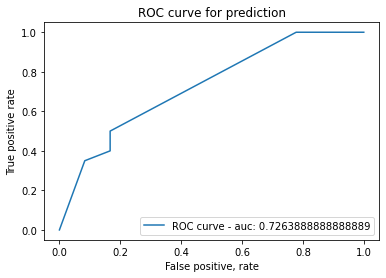

In [68]:
# predict
predt_y = tree.predict(test_x)

fpr, tpr, thres = roc_curve(test_y_int, predt_y)
plt.plot(fpr, tpr, label="ROC curve - auc: {}".format(auc(fpr, tpr)))
plt.legend()
plt.xlabel("False positive, rate")
plt.ylabel("True positive rate")
plt.title("ROC curve for prediction")
plt.show()

#### 2) recurrence event 확률에 영향을 미치는 변수를 파악하시오.

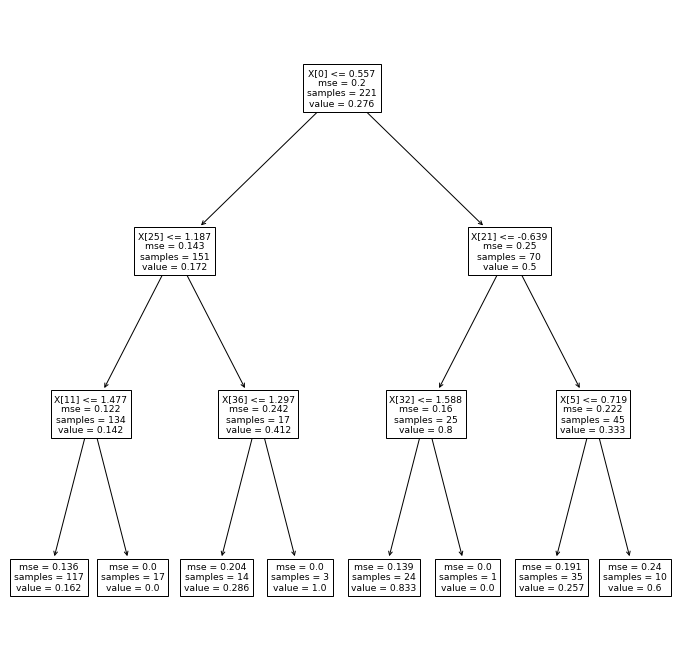

In [74]:
plt.figure(figsize=(12,12))
plot_tree(tree);

X 데이터의 0번째 변수인 deg_malig , 25번째와 21번째 변수인 inv_nodes 변수가 종속변수에 주요한 영향을 끼친다고 할 수 있다.

## 3. Logistic regression과 Regression tree의 결과를 비교하시오.

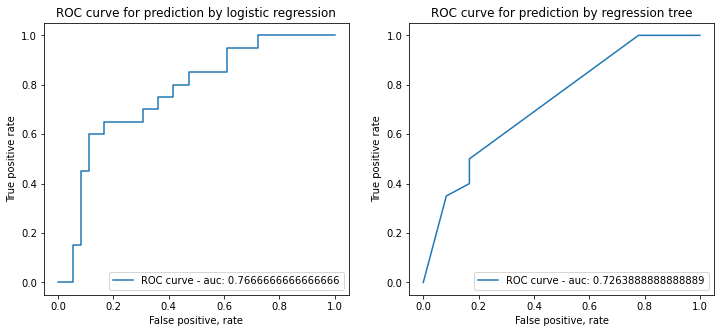

In [85]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
fpr, tpr, thres = roc_curve(test_y_int, pred_y_1)
plt.plot(fpr, tpr, label="ROC curve - auc: {}".format(auc(fpr, tpr)))
plt.legend()
plt.xlabel("False positive, rate")
plt.ylabel("True positive rate")
plt.title("ROC curve for prediction by logistic regression")


plt.subplot(1,2,2)
fpr, tpr, thres = roc_curve(test_y_int, predt_y)
plt.plot(fpr, tpr, label="ROC curve - auc: {}".format(auc(fpr, tpr)))
plt.legend()
plt.xlabel("False positive, rate")
plt.ylabel("True positive rate")
plt.title("ROC curve for prediction by regression tree")
plt.show()

logistic regression을 이용한 예측과 regression tree를 이용한 예측의 ROC curve 및 auc값을 비교해보면, logistic regression의 auc값이 좀 더 높은 것을 확인할 수 있다. 따라서 두 모델 중 logistic regression의 예측 정확도가 regression tree보다 높다.